In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import LSTM,Conv1D,Conv2D,MaxPooling2D,MaxPooling1D,Flatten
from keras.layers import Dense, Dropout
from tensorflow.compat.v1.keras.layers import CuDNNLSTM,Bidirectional

In [2]:
df = pd.read_csv('../Tweet_Sentiment/2022_final.csv').drop(['fark', 'tweet_count'], axis= 1).set_index('Unnamed: 0').sort_index()

In [3]:
df

,şimdi,açılış,avg_polar
Unnamed: 0,,,
2022-01-03,1926.66,1871.25,0.522727
2022-01-04,1963.59,1941.26,0.461856
2022-01-05,2005.29,1965.52,0.524074
2022-01-06,2007.55,1993.06,0.502137
2022-01-07,2033.32,2020.27,0.535238
...,...,...,...
2022-10-12,3517.75,3576.84,0.488859
2022-10-13,3553.43,3529.78,0.497640
2022-10-14,3626.96,3584.94,0.479313


In [4]:
scaler = MinMaxScaler()
scaler = scaler.fit(df)
df_for_training_scaled = scaler.transform(df)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(df.loc[:,['şimdi']])

df_for_training_scaled

array([[0.0377109 , 0.        , 0.48641017],
       [0.05621068, 0.03542353, 0.31186336],
       [0.07709995, 0.04769856, 0.49027207],
       [0.07823208, 0.0616332 , 0.4273677 ],
       [0.09114135, 0.07540086, 0.52228444],
       [0.0970725 , 0.09021084, 0.53278317],
       [0.09750832, 0.09554385, 0.36751115],
       [0.10661544, 0.10074025, 0.36751115],
       [0.1098415 , 0.09422325, 0.31095378],
       [0.11098365, 0.10124622, 0.4423693 ],
       [0.11741073, 0.10993893, 0.55222334],
       [0.06434597, 0.10704473, 0.30112036],
       [0.0955296 , 0.05440783, 0.34177297],
       [0.08156835, 0.09358572, 0.26895333],
       [0.08004048, 0.06921781, 0.3517265 ],
       [0.02951048, 0.0676088 , 0.27474242],
       [0.04693323, 0.02862318, 0.35479953],
       [0.04998898, 0.04043777, 0.4920421 ],
       [0.07329279, 0.02477269, 0.46316257],
       [0.06602413, 0.06858028, 0.31250985],
       [0.07605298, 0.06731533, 0.59985341],
       [0.0821795 , 0.0722132 , 0.40408492],
       [0.

In [5]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 5  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future,[0]])

trainX, trainY = np.array(trainX), np.array(trainY)

print('TrainX shape = {}.'.format(trainX.shape))
print('TrainY shape = {}.'.format(trainY.shape))

TrainX shape = (194, 5, 3).
TrainY shape = (194, 1, 1).


In [6]:
trainY

array([[[0.0970725 ]],

       [[0.09750832]],

       [[0.10661544]],

       [[0.1098415 ]],

       [[0.11098365]],

       [[0.11741073]],

       [[0.06434597]],

       [[0.0955296 ]],

       [[0.08156835]],

       [[0.08004048]],

       [[0.02951048]],

       [[0.04693323]],

       [[0.04998898]],

       [[0.07329279]],

       [[0.06602413]],

       [[0.07605298]],

       [[0.0821795 ]],

       [[0.07557208]],

       [[0.05336032]],

       [[0.04630205]],

       [[0.07323769]],

       [[0.07802669]],

       [[0.09591532]],

       [[0.09382138]],

       [[0.10002304]],

       [[0.07542179]],

       [[0.0935659 ]],

       [[0.09520398]],

       [[0.07945437]],

       [[0.09070052]],

       [[0.09351581]],

       [[0.08319641]],

       [[0.08248006]],

       [[0.        ]],

       [[0.05060514]],

       [[0.04749429]],

       [[0.05937663]],

       [[0.06748187]],

       [[0.0861169 ]],

       [[0.06981625]],

       [[0.07311245]],

       [[0.08013

In [7]:
X_train_lstm_without_twitter, X_test_lstm_without_twitter, y_train_lstm_without_twitter, y_test_lstm_without_twitter = train_test_split(trainX[:,:,:-1], trainY, test_size=0.2, shuffle=False)

X_train_lstm_twitter, X_test_lstm_twitter, y_train_lstm_twitter, y_test_lstm_twitter = train_test_split(trainX, trainY, test_size=0.2, shuffle=False)

X_train_lstm_without_twitter.shape,X_train_lstm_twitter.shape

((155, 5, 2), (155, 5, 3))

In [8]:
def build_model(input_shape):
    tf.random.set_seed(12345)
    cnn_lstm_model = Sequential()

    cnn_lstm_model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))

    cnn_lstm_model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))
    cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))
    # cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))

    cnn_lstm_model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))

    cnn_lstm_model.add(Dense(32, activation='relu'))


    cnn_lstm_model.add(Dense(trainY.shape[2], activation='relu'))

    # cnn_lstm_model.build(input_shape=(trainX.shape[0], trainX.shape[1], trainX.shape[2]))

    cnn_lstm_model.compile(optimizer='adam', loss='mse')
    cnn_lstm_model.summary()
    return cnn_lstm_model

In [9]:
cnn_lstm_model_without_twitter=build_model((X_train_lstm_without_twitter.shape[1],X_train_lstm_without_twitter.shape[2]))
cnn_lstm_model_twitter=build_model((X_train_lstm_twitter.shape[1],X_train_lstm_twitter.shape[2]))

history_without_twitter = cnn_lstm_model_without_twitter.fit(X_train_lstm_without_twitter, y_train_lstm_without_twitter, epochs=50, batch_size=64, verbose=1, )


history_twitter = cnn_lstm_model_twitter.fit(X_train_lstm_twitter, y_train_lstm_twitter, epochs=50, batch_size=64, verbose=1, )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 128)            640       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 128)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 1, 512)           659456    
 l)                                                              
                                                        

3/3 [==============================] - 0s 11ms/step - loss: 0.0196
Epoch 3/50
3/3 [==============================] - 0s 11ms/step - loss: 0.0209
Epoch 4/50
3/3 [==============================] - 0s 11ms/step - loss: 0.0069
Epoch 5/50
3/3 [==============================] - 0s 11ms/step - loss: 0.0104
Epoch 6/50
3/3 [==============================] - 0s 11ms/step - loss: 0.0059
Epoch 7/50
3/3 [==============================] - 0s 11ms/step - loss: 0.0038
Epoch 8/50
3/3 [==============================] - 0s 11ms/step - loss: 0.0038
Epoch 9/50
3/3 [==============================] - 0s 11ms/step - loss: 0.0027
Epoch 10/50
3/3 [==============================] - 0s 11ms/step - loss: 0.0031
Epoch 11/50
3/3 [==============================] - 0s 11ms/step - loss: 0.0020
Epoch 12/50
3/3 [==============================] - 0s 11ms/step - loss: 0.0020
Epoch 13/50
3/3 [==============================] - 0s 11ms/step - loss: 0.0014
Epoch 14/50
3/3 [==============================] - 0s 11ms/step - loss:

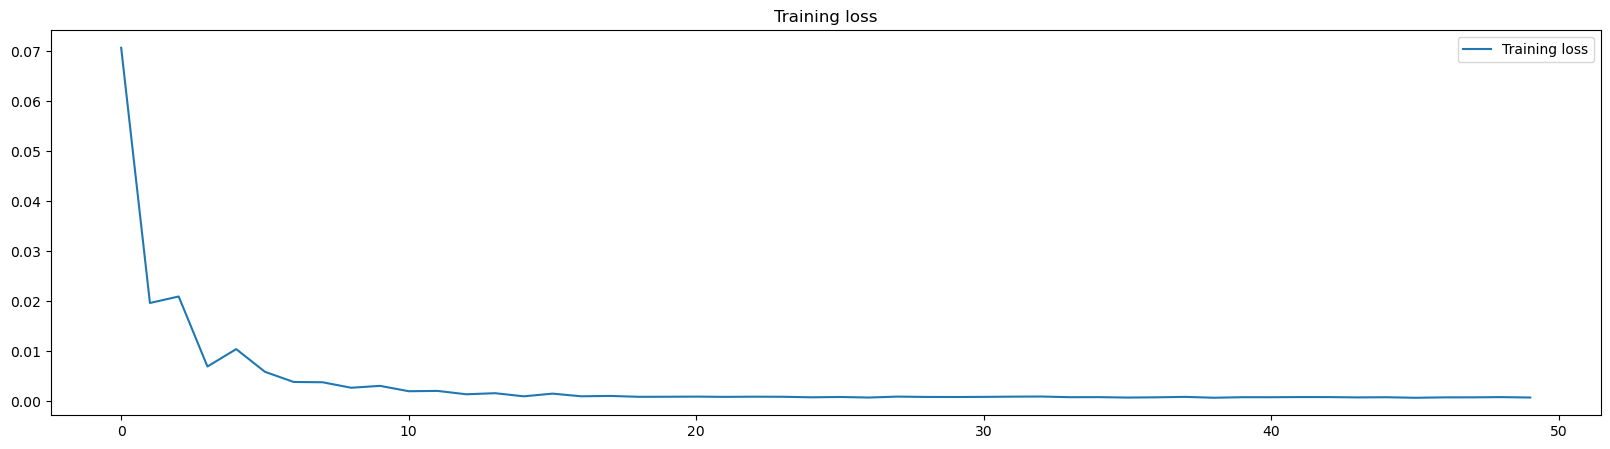

In [17]:
plt.figure(figsize=(20,5))
plt.plot(history_twitter.history['loss'], label='Training loss')
plt.title('Training loss')
plt.legend()

In [ ]:
training_dates= df_for_training.index[:X_train_lstm_without_twitter.shape[0]]
#Make prediction
training_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_train_lstm_without_twitter)

training_prediction_twitter = cnn_lstm_model_twitter.predict(X_train_lstm_twitter)

training_prediction_without_twitter=training_prediction_without_twitter.reshape(training_prediction_without_twitter.shape[0], training_prediction_without_twitter.shape[2])

training_prediction_twitter=training_prediction_twitter.reshape(training_prediction_twitter.shape[0], training_prediction_twitter.shape[2])

y_train_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(training_prediction_without_twitter)

y_train_pred_lstm_twitter = scaler_for_inference.inverse_transform(training_prediction_twitter)

y_train_lstm_reshaped_without_twitter=y_train_lstm_without_twitter.reshape(y_train_lstm_without_twitter.shape[0], y_train_lstm_without_twitter.shape[2])

y_train_actual_lstm = scaler_for_inference.inverse_transform(y_train_lstm_reshaped_without_twitter)

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt

def plot_predictions_with_dates (type,twitter,dates,y_actual_lstm,y_pred_lstm):
    predicted_features=['şimdi']
    for i,predicted_feature in enumerate(predicted_features):
        plt.figure(figsize=(15,6))
        if twitter :
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature After adding twitter sentiment analysis')
        else:
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature without twitter sentiment analysis')
        sns.lineplot(x=dates, y=y_actual_lstm[:,i],label='Actual')
        sns.lineplot(x=dates, y=y_pred_lstm[:, i], label='Predicted')
        plt.show()
        error=mean_squared_error(y_actual_lstm[:,i], y_pred_lstm[:, i])
        print(f'Mean square error for {predicted_feature} ={error}')
    print('Total mean square error', mean_squared_error(y_actual_lstm, y_pred_lstm))

In [23]:
testing_dates= df.index[-X_test_lstm_without_twitter.shape[0]:]
#Make prediction
testing_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_test_lstm_without_twitter)
testing_prediction_twitter = cnn_lstm_model_twitter.predict(X_test_lstm_twitter)

testing_prediction_without_twitter=testing_prediction_without_twitter.reshape(testing_prediction_without_twitter.shape[0], testing_prediction_without_twitter.shape[2])
testing_prediction_twitter=testing_prediction_twitter.reshape(testing_prediction_twitter.shape[0], testing_prediction_twitter.shape[2])

y_test_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(testing_prediction_without_twitter)
y_test_pred_lstm_twitter = scaler_for_inference.inverse_transform(testing_prediction_twitter)

y_test_actual_lstm_reshaped_without_twitter=y_test_lstm_without_twitter.reshape(y_test_lstm_without_twitter.shape[0], y_test_lstm_without_twitter.shape[2])


y_test_actual_lstm = scaler_for_inference.inverse_transform(y_test_actual_lstm_reshaped_without_twitter)

2/2 [==============================] - 0s 16ms/step


In [28]:
training_dates= df.index[:X_train_lstm_twitter.shape[0]]
plot_predictions_with_dates('Training',True,training_dates,y_train_lstm_twitter,y_train_pred_lstm_twitter)

NameError: name 'y_train_pred_lstm_twitter' is not defined

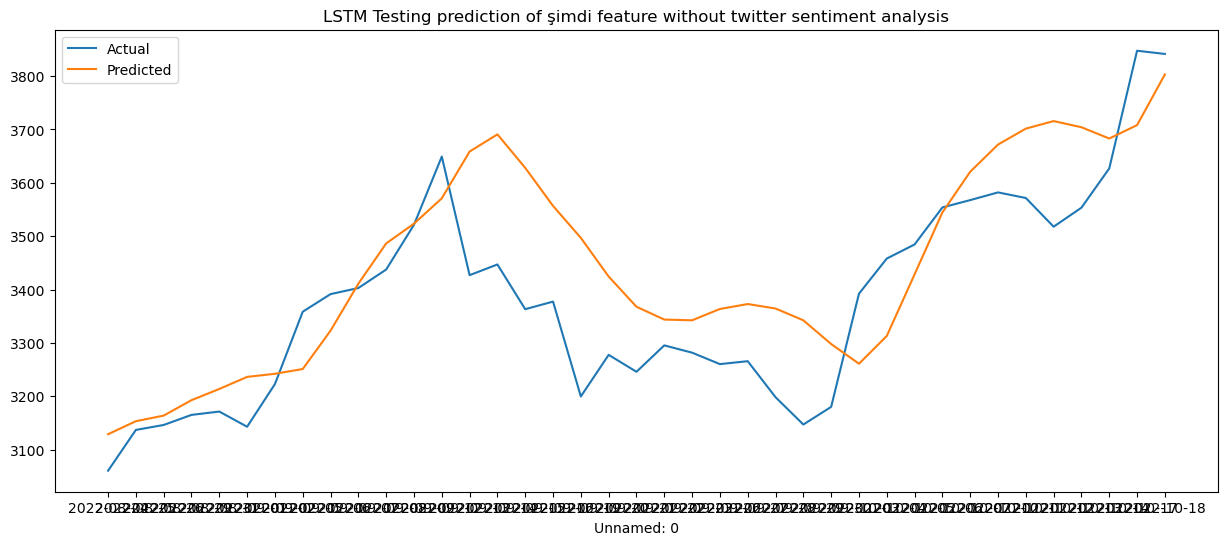

Mean square error for şimdi =16543.330631068875
Total mean square error 16543.330631068875


In [12]:
plot_predictions_with_dates('Testing',False,testing_dates,y_test_actual_lstm,y_test_pred_lstm_without_twitter)

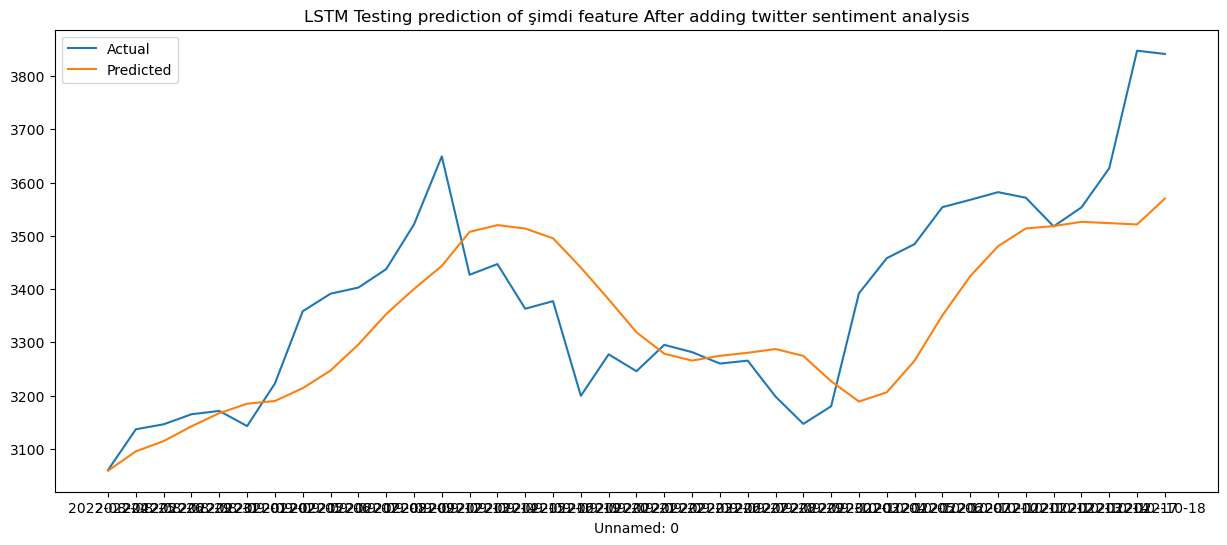

Mean square error for şimdi =17771.997284409656
Total mean square error 17771.997284409656


In [13]:
plot_predictions_with_dates('Testing',True,testing_dates,y_test_actual_lstm,y_test_pred_lstm_twitter)

In [25]:
y_test_pred_lstm_twitter

array([[3058.9155],
       [3095.3213],
       [3114.5479],
       [3142.2976],
       [3166.9983],
       [3184.8164],
       [3189.849 ],
       [3213.8938],
       [3247.038 ],
       [3295.936 ],
       [3353.0146],
       [3400.2383],
       [3443.46  ],
       [3507.5195],
       [3520.1455],
       [3513.6907],
       [3495.4004],
       [3440.4978],
       [3380.6565],
       [3318.9165],
       [3278.589 ],
       [3265.7742],
       [3274.7083],
       [3280.3853],
       [3287.4841],
       [3274.5076],
       [3226.8584],
       [3188.8586],
       [3206.1958],
       [3265.5107],
       [3350.638 ],
       [3424.109 ],
       [3480.4556],
       [3513.773 ],
       [3518.3726],
       [3526.2534],
       [3523.8613],
       [3521.4045],
       [3569.8674]], dtype=float32)

In [26]:
y_test_actual_lstm

array([[3060.3 ],
       [3136.77],
       [3146.1 ],
       [3164.96],
       [3171.21],
       [3142.74],
       [3222.74],
       [3358.37],
       [3391.38],
       [3402.81],
       [3437.41],
       [3521.38],
       [3649.21],
       [3426.88],
       [3446.96],
       [3363.12],
       [3377.33],
       [3199.54],
       [3277.5 ],
       [3245.76],
       [3295.27],
       [3281.61],
       [3260.15],
       [3265.64],
       [3198.16],
       [3146.89],
       [3179.99],
       [3392.13],
       [3458.03],
       [3484.42],
       [3553.85],
       [3567.6 ],
       [3582.03],
       [3571.55],
       [3517.75],
       [3553.43],
       [3626.96],
       [3847.62],
       [3841.56]])